#Combine Guided SmoothGrad with Grad CAM

### Essential libraries

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

### VGG16 model and preprocessing

In [ ]:
# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


<ipython-input-3-8f20ba747e1c>:101: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  cam = Image.fromarray(cam).resize(image.size, Image.ANTIALIAS)
<ipython-input-3-8f20ba747e1c>:118: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  smooth_grad_map_resized = np.array(Image.fromarray((smooth_grad_map * 255).astype(np.uint8)).resize(grad_cam_map.shape[::-1], Image.ANTIALIAS)).astype(np.float32) / 255


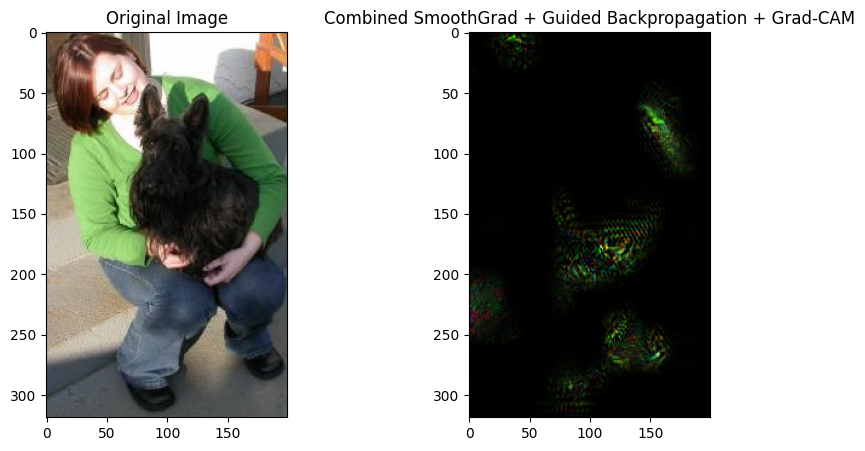

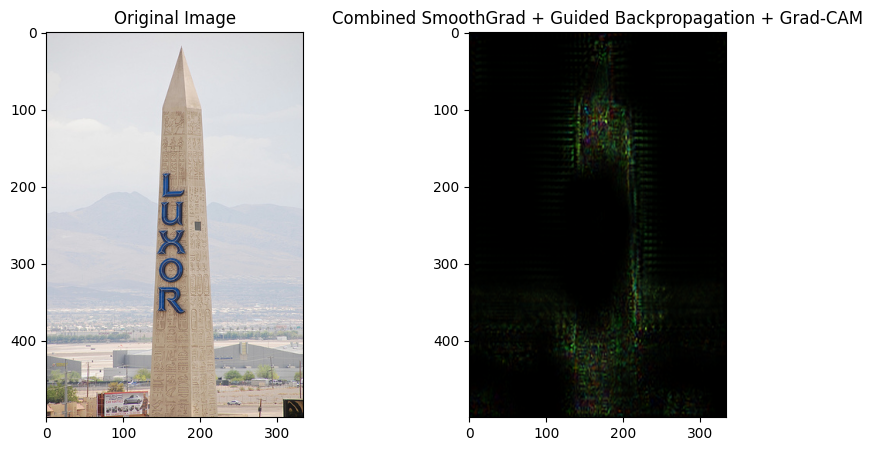

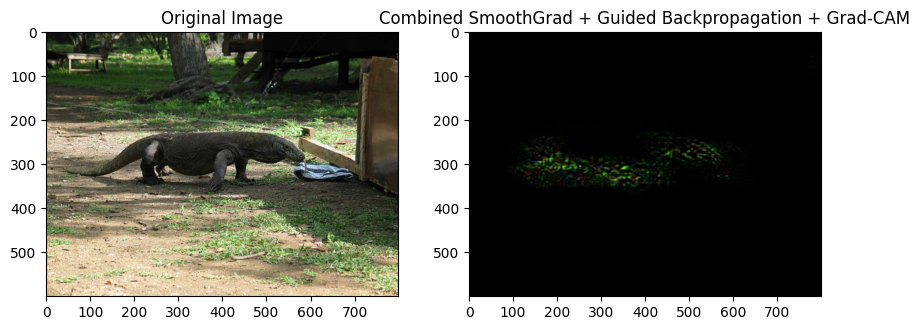

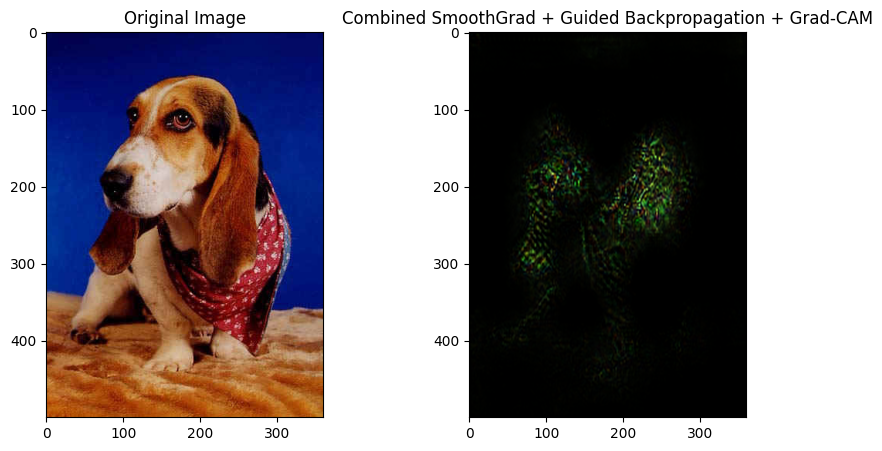

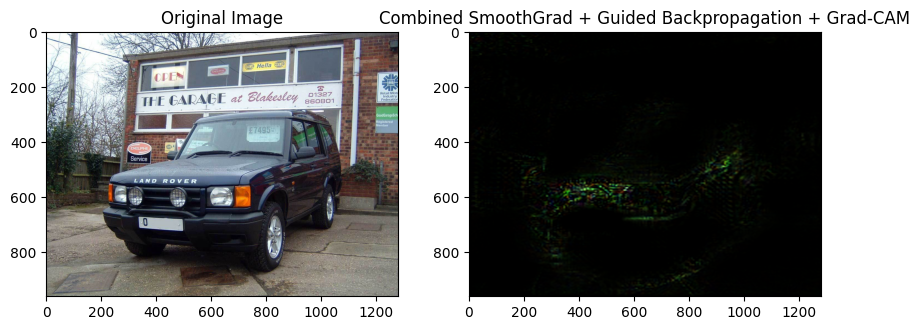

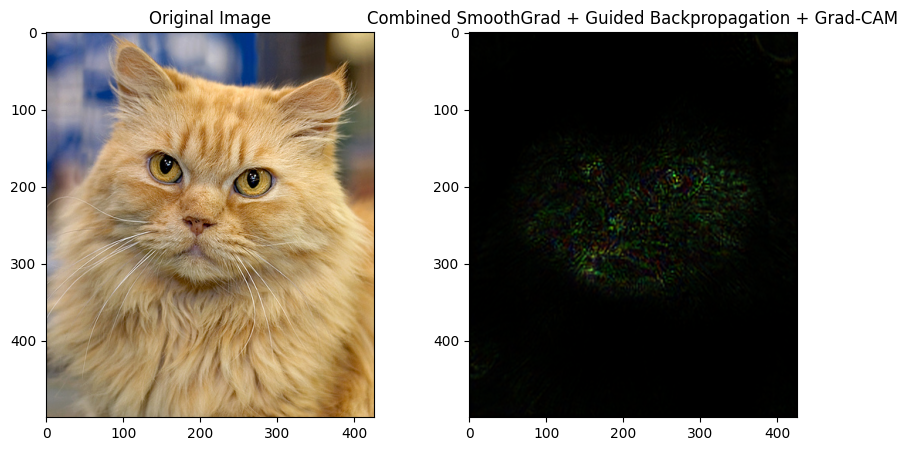

In [ ]:
# Function for Guided Backpropagation
def guided_backprop(model, image, target_class):
    image_tensor = preprocess(image).unsqueeze(0)
    image_tensor.requires_grad = True

    model.zero_grad()
    output = model(image_tensor)
    target = output[0][target_class]
    target.backward()

    grad = image_tensor.grad.data[0].cpu().numpy()
    grad = np.maximum(grad, 0)  # Apply ReLU to gradients

    return grad

# Function for SmoothGrad
def smooth_grad(model, image, target_class, n_samples=50, noise_level=0.1):
    image_np = np.array(image).astype(np.float32) / 255.0
    image_tensor = preprocess(image).unsqueeze(0).numpy()
    smooth_grad = np.zeros_like(image_tensor)

    for i in range(n_samples):
        noisy_image_np = image_tensor + np.random.normal(0, noise_level, image_tensor.shape)
        noisy_image_np = np.clip(noisy_image_np, 0, 1)
        noisy_image_tensor = torch.tensor(noisy_image_np).float()
        noisy_image_tensor = noisy_image_tensor.squeeze(0)  # Remove the batch dimension
        noisy_image_pil = transforms.ToPILImage()(noisy_image_tensor)
        grad = guided_backprop(model, noisy_image_pil, target_class)
        smooth_grad += grad

    smooth_grad /= n_samples
    return smooth_grad

# Function for Grad-CAM
def grad_cam(model, image, target_layer, target_class):
    model.eval()
    features = []
    gradients = []

    def forward_hook(module, input, output):
        features.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks to the target layer
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Image preprocessing and forward pass
    tensor = preprocess(image).unsqueeze(0)
    tensor.requires_grad = True
    output = model(tensor)

    target = output[0][target_class]

    model.zero_grad()
    target.backward()

    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()

    # Get the gradients and feature map
    gradients = gradients[0].cpu().data.numpy()[0]
    feature_map = features[0].cpu().data.numpy()[0]

    # Pool the gradients across the width and height dimensions
    pooled_gradients = np.mean(gradients, axis=(1, 2))

    # Weight the feature map with the pooled gradients
    for i in range(pooled_gradients.shape[0]):
        feature_map[i, ...] *= pooled_gradients[i]

    # Generate the CAM
    cam = np.mean(feature_map, axis=0)
    cam = np.maximum(cam, 0)  # Apply ReLU
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)

    # Resize the CAM to the size of the input image
    cam = Image.fromarray(cam).resize(image.size, Image.ANTIALIAS)
    cam = np.array(cam)

    return cam

# Function to combine SmoothGrad + Guided Backpropagation with Grad-CAM
def combined_grad_cam(model, image, target_layer, target_class, n_samples=50, noise_level=0.2):
    grad_cam_map = grad_cam(model, image, target_layer, target_class)
    smooth_grad_map = smooth_grad(model, image, target_class, n_samples, noise_level)

    # Normalize the smooth_grad_map
    smooth_grad_map = smooth_grad_map[0]  # Remove the batch dimension
    smooth_grad_map = np.transpose(smooth_grad_map, (1, 2, 0))
    smooth_grad_map = smooth_grad_map - smooth_grad_map.min()
    smooth_grad_map = smooth_grad_map / smooth_grad_map.max()

    # Resize smooth_grad_map to match grad_cam_map
    smooth_grad_map_resized = np.array(Image.fromarray((smooth_grad_map * 255).astype(np.uint8)).resize(grad_cam_map.shape[::-1], Image.ANTIALIAS)).astype(np.float32) / 255

    # Convert grad_cam_map to range [0, 1]
    grad_cam_map = grad_cam_map / 255.0

    # Combine the Grad-CAM and SmoothGrad maps
    combined_map = grad_cam_map[..., np.newaxis] * smooth_grad_map_resized  # Broadcasting
    combined_map = combined_map - combined_map.min()
    combined_map = combined_map / combined_map.max()

    return combined_map

# Function to display the results
def display_combined_results(image_path, target_class, target_layer):
    image = Image.open(image_path).convert('RGB')
    result = combined_grad_cam(model, image, target_layer, target_class)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(result, cmap='jet')
    plt.title('Combined SmoothGrad + Guided Backpropagation + Grad-CAM')
    plt.show()

# Example usage for multiple images
image_paths = [
    '/content/n02097298_Scotch_terrier.JPEG',
    '/content/n03837869_obelisk.JPEG',
    '/content/n01695060_Komodo_dragon.JPEG',
    '/content/n02088238_basset.JPEG',
    '/content/n03594945_jeep.JPEG',
    '/content/n02123394_Persian_cat.JPEG'
]

target_classes = [
    109,  # Scotch terrier
    538,  # Obelisk
    473,  # Komodo dragon
    161,  # Basset
    609,  # Jeep
    283   # Persian cat
]

target_layer = model.features[29]

# Generate and display results for each image
for image_path, target_class in zip(image_paths, target_classes):
    display_combined_results(image_path, target_class, target_layer)


# Creating a adversarial sample and obtaining its saliency map

Original Class: 283, Predicted Class after Attack: 281


<ipython-input-4-e3a9a0ef9a90>:89: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  cam = Image.fromarray(cam).resize((224, 224), Image.ANTIALIAS)
<ipython-input-4-e3a9a0ef9a90>:104: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  smooth_grad_map_resized = np.array(Image.fromarray((smooth_grad_map * 255).astype(np.uint8)).resize(grad_cam_map.shape[::-1], Image.ANTIALIAS)).astype(np.float32) / 255


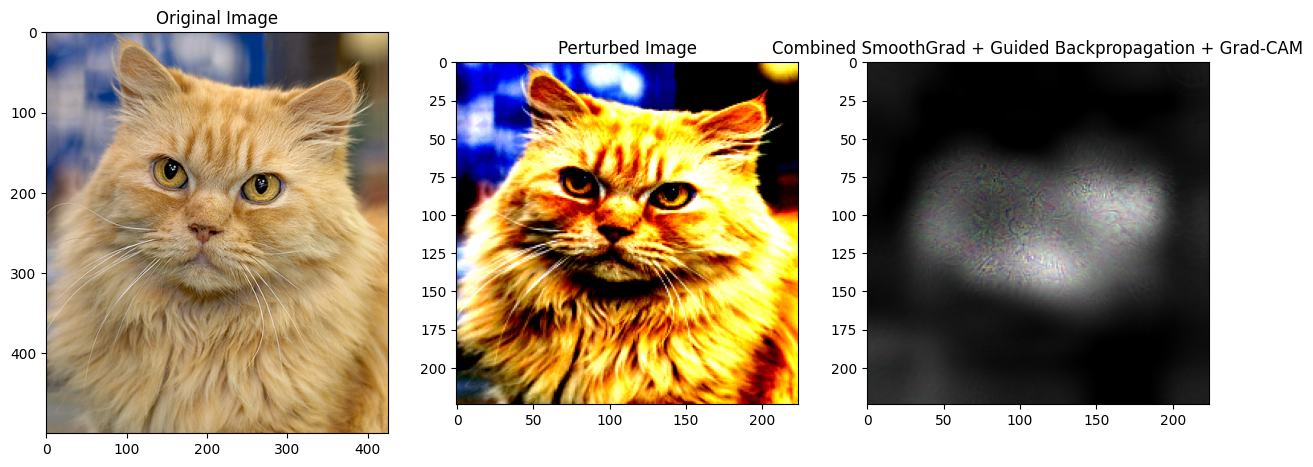

In [4]:
# Function to load and preprocess image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return preprocess(image).unsqueeze(0)

# Function for FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Function to generate perturbed image
def generate_perturbed_image(model, image, target_class, epsilon=0.01):
    image.requires_grad = True
    output = model(image)
    loss = F.nll_loss(F.log_softmax(output, dim=1), torch.tensor([target_class]))
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = fgsm_attack(image, epsilon, data_grad)
    return perturbed_image

# Function to predict the class of an image
def predict_image_class(model, image):
    output = model(image)
    _, predicted_class = torch.max(output, 1)
    return predicted_class.item()

# Function for Grad-CAM
def grad_cam(model, image, target_layer, target_class):
    features = []
    gradients = []

    def forward_hook(module, input, output):
        features.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    tensor = image
    tensor.requires_grad = True
    output = model(tensor)

    target = output[0][target_class]

    model.zero_grad()
    target.backward()

    handle_forward.remove()
    handle_backward.remove()

    gradients = gradients[0].cpu().data.numpy()[0]
    feature_map = features[0].cpu().data.numpy()[0]

    pooled_gradients = np.mean(gradients, axis=(1, 2))

    for i in range(pooled_gradients.shape[0]):
        feature_map[i, ...] *= pooled_gradients[i]

    cam = np.mean(feature_map, axis=0)
    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)

    cam = Image.fromarray(cam).resize((224, 224), Image.ANTIALIAS)
    cam = np.array(cam)

    return cam

# Function to combine SmoothGrad + Guided Backpropagation with Grad-CAM
def combined_grad_cam(model, image, target_layer, target_class, n_samples=50, noise_level=0.1):
    grad_cam_map = grad_cam(model, image, target_layer, target_class)
    smooth_grad_map = smooth_grad(model, image, target_class, n_samples, noise_level)

    smooth_grad_map = smooth_grad_map[0]
    smooth_grad_map = np.transpose(smooth_grad_map, (1, 2, 0))
    smooth_grad_map = smooth_grad_map - smooth_grad_map.min()
    smooth_grad_map = smooth_grad_map / smooth_grad_map.max()

    smooth_grad_map_resized = np.array(Image.fromarray((smooth_grad_map * 255).astype(np.uint8)).resize(grad_cam_map.shape[::-1], Image.ANTIALIAS)).astype(np.float32) / 255
    grad_cam_map = grad_cam_map / 255.0

    combined_map = grad_cam_map[..., np.newaxis] * smooth_grad_map_resized
    combined_map = combined_map - combined_map.min()
    combined_map = combined_map / combined_map.max()

    return combined_map

# Function for SmoothGrad
def smooth_grad(model, image, target_class, n_samples=50, noise_level=0.1):
    image_tensor = image.clone().detach()
    smooth_grad = np.zeros_like(image_tensor.numpy())

    for i in range(n_samples):
        noisy_image = image_tensor + torch.randn(image_tensor.size()) * noise_level
        noisy_image = torch.clamp(noisy_image, 0, 1)
        noisy_image.requires_grad = True
        output = model(noisy_image)
        loss = output[0, target_class]
        model.zero_grad()
        loss.backward()
        grad = noisy_image.grad.data.cpu().numpy()
        smooth_grad += grad

    smooth_grad /= n_samples
    return smooth_grad

# Function to display the results
def display_combined_results(original_image_path, perturbed_image, original_class, target_layer):
    original_image = load_image(original_image_path)
    perturbed_image_np = perturbed_image.squeeze(0).detach().cpu().numpy()
    perturbed_image_np = np.transpose(perturbed_image_np, (1, 2, 0))
    perturbed_image_np = (perturbed_image_np * 255).astype(np.uint8)
    perturbed_image_pil = Image.fromarray(perturbed_image_np)

    result = combined_grad_cam(model, original_image, target_layer, original_class)

    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(Image.open(original_image_path).convert('RGB'))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(perturbed_image_pil)
    plt.title('Perturbed Image')

    plt.subplot(1, 3, 3)
    plt.imshow(result, cmap='jet')
    plt.title('Combined SmoothGrad + Guided Backpropagation + Grad-CAM')
    plt.show()

# Example usage
image_path = '/content/n02123394_Persian_cat.JPEG'
original_class = 283  # Persian cat
epsilon = 0.02  # Perturbation magnitude

# Load and preprocess image
original_image = load_image(image_path)

# Generate perturbed image
perturbed_image = generate_perturbed_image(model, original_image, original_class, epsilon)

# Predict the class of the perturbed image
predicted_class = predict_image_class(model, perturbed_image)
print(f'Original Class: {original_class}, Predicted Class after Attack: {predicted_class}')

# Select the target layer for Grad-CAM
target_layer = model.features[29]

# Display results
display_combined_results(image_path, perturbed_image, original_class, target_layer)
